In [3]:
import os
import numpy as np
import healpy as hp
import logging
from pathlib import Path
from matplotlib import pyplot as plt
import h5py


In [64]:

def save_merged_stats_to_hdf5(merged_stats, output_path):
    def _save_group(group, data):
        for key, value in data.items():
            # 数値キーを文字列に変換
            key_str = f"{key}"
            
            if isinstance(value, dict):
                # 辞書の場合は新しいグループを作成
                subgroup = group.create_group(key_str)
                _save_group(subgroup, value)
            else:
                # リストまたはnumpy配列の場合はデータセットとして保存
                if isinstance(value, list):
                    if len(value) > 0:
                        value = np.array(value)
                    else:
                        value = np.array([])
                try:
                    group.create_dataset(key_str, data=value, compression="gzip")
                except (TypeError, ValueError):
                    # 特殊なデータ型の場合は文字列として保存
                    group.create_dataset(key_str, data=str(value))

    with h5py.File(output_path, 'w') as f:
        _save_group(f, merged_stats)

def load_dict_from_hdf5(hdf5_file, path='/'):
    data = {}
    for key in hdf5_file[path]:
        current_path = f"{path}{key}"
        item = hdf5_file[current_path]
        if isinstance(item, h5py.Group):
            data[key] = load_dict_from_hdf5(hdf5_file, path=current_path + '/')
        else:
            data[key] = item[()]
    return data

def load_results_from_hdf5(hdf5_path):
    results = {}
    with h5py.File(hdf5_path, 'r') as hf:
        results = load_dict_from_hdf5(hf)
    return results

In [65]:
tiled_dirs = list(Path("/lustre/work/akira.tokiwa/Projects/LensingSSC/output").glob("tiled/stats/*.h5"))
bigbox_dirs = list(Path("/lustre/work/akira.tokiwa/Projects/LensingSSC/output").glob("bigbox/stats/*.h5"))

In [66]:
def create_empty_results(tiled_dirs):
    results = load_results_from_hdf5(tiled_dirs[0])
    new_results = {}
    for ngal in results.keys():
        new_results[ngal] = {}
        for sl in results[ngal].keys():
            new_results[ngal][sl] = {}
            if sl in ['cl', 'equilateral', 'isosceles', 'squeezed']:
                new_results[ngal][sl] = []
            else:
                for key in results[ngal][sl].keys():
                    new_results[ngal][sl][key] = []
    return new_results

def insert_stats(tiled_dirs, indices=None):
    results = create_empty_results(tiled_dirs)
    if indices is None:
        exclude_idx = [130, 132, 134]
    else:
        exclude_idx = indices
    for tiled_dir in tiled_dirs:
        stats = load_results_from_hdf5(tiled_dir)
        for ngal in stats.keys():
            for sl in stats[ngal].keys():
                if sl in ['cl', 'equilateral', 'isosceles', 'squeezed']:
                    filtered_stats = np.delete(stats[ngal][sl], exclude_idx, axis=0)
                    results[ngal][sl].append(filtered_stats)
                else:
                    for key in stats[ngal][sl].keys():
                        filtered_stats = np.delete(stats[ngal][sl][key], exclude_idx, axis=0)
                        results[ngal][sl][key].append(filtered_stats)

    for ngal in results.keys():
        for sl in results[ngal].keys():
            if sl in ['cl', 'equilateral', 'isosceles', 'squeezed']:
                results[ngal][sl] = np.concatenate(results[ngal][sl], axis=0)
            else:
                for key in results[ngal][sl].keys():
                    results[ngal][sl][key] = np.concatenate(results[ngal][sl][key], axis=0)
    return results

In [67]:
def create_empty_merged_stats(tiled_dirs, zs_list=[0.5, 1.0, 1.5, 2.0, 2.5]):
    desired_stats = ['cov', 'diags', 'corr', 'stds', 'means']
    results = load_results_from_hdf5(tiled_dirs[0])
    new_results = {}
    for zs in zs_list:
        new_results[zs] = {}
        for ngal in results.keys():
            new_results[zs][ngal] = {}
            new_results[zs][ngal]["combined_correlation"] = []
            for sl in results[ngal].keys():
                new_results[zs][ngal][sl] = {}
                if sl in ['cl', 'equilateral', 'isosceles', 'squeezed']:
                    new_results[zs][ngal][sl] = {}
                    for stat in desired_stats:
                        new_results[zs][ngal][sl][stat] = []
                else:
                    new_results[zs][ngal][sl]["combined_nonlinear"] = []
                    for key in results[ngal][sl].keys():
                        new_results[zs][ngal][sl][key] = {}
                        for stat in desired_stats:
                            new_results[zs][ngal][sl][key][stat] = []
    return new_results


def calculate_merged_stats(tiled_dirs, bigbox_dirs, zs_list, indices=None):
    merged_stats_tiled = create_empty_merged_stats(tiled_dirs, zs_list)
    merged_stats_bigbox = create_empty_merged_stats(bigbox_dirs, zs_list)
    for zs in zs_list:
        tiled_dirs_zs = [str(p) for p in tiled_dirs if f"zs{zs}" in p.name]
        bigbox_dirs_zs = [str(p) for p in bigbox_dirs if f"zs{zs}" in p.name]

        stats_tiled = insert_stats(tiled_dirs_zs, indices)
        stats_bigbox = insert_stats(bigbox_dirs_zs, indices)

        for ngal in stats_tiled.keys():
            for sl in stats_tiled[ngal].keys():
                if sl in ['cl', 'equilateral', 'isosceles', 'squeezed']:
                    merged_stats_tiled[zs][ngal]["combined_correlation"].append(stats_tiled[ngal][sl])
                    merged_stats_bigbox[zs][ngal]["combined_correlation"].append(stats_bigbox[ngal][sl])
                    for stat in ['cov', 'diags', 'corr', 'stds', 'means']:
                        merged_stats_tiled[zs][ngal][sl][stat] = compute_stats(stats_tiled[ngal][sl], stat)
                        merged_stats_bigbox[zs][ngal][sl][stat] = compute_stats(stats_bigbox[ngal][sl], stat)
                else:
                    for key in stats_tiled[ngal][sl].keys():
                        if key in ['sigma0', "sigma1"]:
                            continue
                            #merged_stats_tiled[zs][ngal][sl][key] = stats_tiled[ngal][sl][key]
                            #merged_stats_bigbox[zs][ngal][sl][key] = stats_bigbox[ngal][sl][key]
                        else:
                            merged_stats_tiled[zs][ngal][sl]["combined_nonlinear"].append(stats_tiled[ngal][sl][key])
                            merged_stats_bigbox[zs][ngal][sl]["combined_nonlinear"].append(stats_bigbox[ngal][sl][key])
                        for stat in ['cov', 'diags', 'corr', 'stds', 'means']:
                            if key in ['sigma0', "sigma1"]:
                                continue
                            merged_stats_tiled[zs][ngal][sl][key][stat] = compute_stats(stats_tiled[ngal][sl][key], stat)
                            merged_stats_bigbox[zs][ngal][sl][key][stat] = compute_stats(stats_bigbox[ngal][sl][key], stat)

                if not sl in ['cl', 'equilateral', 'isosceles', 'squeezed']:
                    merged_stats_tiled[zs][ngal][sl]["combined_nonlinear"] = np.concatenate(merged_stats_tiled[zs][ngal][sl]["combined_nonlinear"], axis=1)
                    merged_stats_bigbox[zs][ngal][sl]["combined_nonlinear"] = np.concatenate(merged_stats_bigbox[zs][ngal][sl]["combined_nonlinear"], axis=1)

            merged_stats_tiled[zs][ngal]["combined_correlation"] = np.concatenate(merged_stats_tiled[zs][ngal]["combined_correlation"], axis=1)
            merged_stats_bigbox[zs][ngal]["combined_correlation"] = np.concatenate(merged_stats_bigbox[zs][ngal]["combined_correlation"], axis=1)

    print("stats_tiled, consist from", merged_stats_tiled[zs][ngal]["combined_correlation"].shape[0], "data points")
    print("stats_bigbox, consist from", merged_stats_bigbox[zs][ngal]["combined_correlation"].shape[0], "data points")

    return merged_stats_tiled, merged_stats_bigbox

def compute_stats(data, stat):
    if stat == 'cov':
        return np.cov(data, rowvar=False)
    elif stat == 'diags':
        return np.diag(np.cov(data, rowvar=False))
    elif stat == 'corr':
        return np.corrcoef(data, rowvar=False)
    elif stat == 'stds':
        return np.std(data, axis=0)
    elif stat == 'means':
        return np.mean(data, axis=0)
    else:
        return None

In [68]:
zs_list = [0.5, 1.0, 1.5, 2.0, 2.5]
ngal_list = [0, 50, 30, 15, 7]
sl_list = [2, 5, 8, 10]
colors = ["tab:blue", "tab:orange", "tab:green", "tab:red", "tab:purple"]

survey_info = {
    '0': 'Noiseless',
    '7': 'DES',
    '15': 'HSC',
    '30': 'LSST',
    '50': 'Roman'
}

# check sigma_0, sigma_1 for noise and smoothing scale

In [60]:
means_tiled = []
means_bigbox = []

for i, zs in enumerate(zs_list):
    tiled_results = insert_stats( [str(p) for p in tiled_dirs if f"zs{zs}" in p.name])
    bigbox_results = insert_stats( [str(p) for p in bigbox_dirs if f"zs{zs}" in p.name])

    for j, sl in enumerate(sl_list):
        mean_tiled = np.mean(tiled_results['0'][str(sl)]['sigma1'])
        mean_bigbox = np.mean(bigbox_results['0'][str(sl)]['sigma1'])

        means_tiled.append(mean_tiled)
        means_bigbox.append(mean_bigbox)

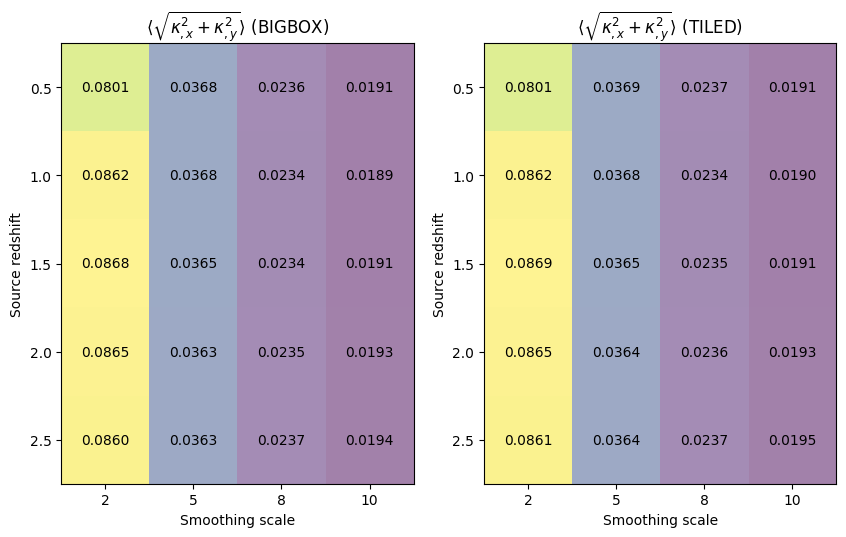

In [61]:
fig, ax = plt.subplots(1, 2, figsize=(10, 7))

ax[0].imshow(np.array(means_bigbox).reshape(5, 4), alpha=0.5)
ax[1].imshow(np.array(means_tiled).reshape(5, 4), alpha=0.5)

ax[0].set_title(r"$\langle \sqrt{\kappa_{,x}^2 + \kappa_{,y}^2} \rangle$" + " (BIGBOX)")
ax[1].set_title(r"$\langle \sqrt{\kappa_{,x}^2 + \kappa_{,y}^2} \rangle$" + " (TILED)")

ax[0].set_xticks(np.arange(4))
ax[0].set_xticklabels(sl_list)
ax[0].set_yticks(np.arange(5))
ax[0].set_yticklabels(zs_list)

ax[1].set_xticks(np.arange(4))
ax[1].set_xticklabels(sl_list)
ax[1].set_yticks(np.arange(5))
ax[1].set_yticklabels(zs_list)

ax[0].set_xlabel("Smoothing scale")
ax[1].set_xlabel("Smoothing scale")

ax[0].set_ylabel("Source redshift")
ax[1].set_ylabel("Source redshift")

for (i, j), val in np.ndenumerate(np.array(means_bigbox).reshape(5, 4)):
    ax[0].text(j, i, f"{val:.4f}", ha='center', va='center', color='black')

for (i, j), val in np.ndenumerate(np.array(means_tiled).reshape(5, 4)):
    ax[1].text(j, i, f"{val:.4f}", ha='center', va='center', color='black')

plt.show()

In [62]:
means_tiled = []
means_bigbox = []

for i, zs in enumerate(zs_list):
    tiled_results = insert_stats( [str(p) for p in tiled_dirs if f"zs{zs}" in p.name])
    bigbox_results = insert_stats( [str(p) for p in bigbox_dirs if f"zs{zs}" in p.name])

    for j, sl in enumerate(sl_list):
        mean_tiled = np.mean(tiled_results['0'][str(sl)]['sigma0'])
        mean_bigbox = np.mean(bigbox_results['0'][str(sl)]['sigma0'])

        means_tiled.append(mean_tiled)
        means_bigbox.append(mean_bigbox)

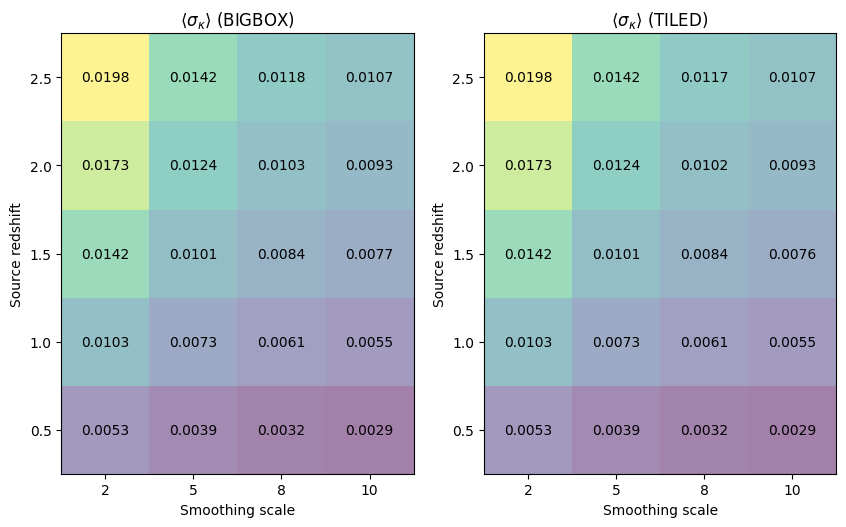

In [63]:
fig, ax = plt.subplots(1, 2, figsize=(10, 7))

ax[0].imshow(np.array(means_bigbox).reshape(5, 4), alpha=0.5, origin="lower")
ax[1].imshow(np.array(means_tiled).reshape(5, 4), alpha=0.5, origin="lower")

ax[0].set_title(r"$\langle \sigma_\kappa \rangle$" + " (BIGBOX)")
ax[1].set_title(r"$\langle \sigma_\kappa \rangle$" + " (TILED)")

ax[0].set_xticks(np.arange(4))
ax[0].set_xticklabels(sl_list)
ax[0].set_yticks(np.arange(5))
ax[0].set_yticklabels(zs_list)

ax[1].set_xticks(np.arange(4))
ax[1].set_xticklabels(sl_list)
ax[1].set_yticks(np.arange(5))
ax[1].set_yticklabels(zs_list)

ax[0].set_xlabel("Smoothing scale")
ax[1].set_xlabel("Smoothing scale")

ax[0].set_ylabel("Source redshift")
ax[1].set_ylabel("Source redshift")

for (i, j), val in np.ndenumerate(np.array(means_bigbox).reshape(5, 4)):
    ax[0].text(j, i, f"{val:.4f}", ha='center', va='center', color='black')

for (i, j), val in np.ndenumerate(np.array(means_tiled).reshape(5, 4)):
    ax[1].text(j, i, f"{val:.4f}", ha='center', va='center', color='black')

plt.show()

In [32]:
sl = 2

means_tiled = []
means_bigbox = []

for i, zs in enumerate(zs_list):
    tiled_results = insert_stats( [str(p) for p in tiled_dirs if f"zs{zs}" in p.name])
    bigbox_results = insert_stats( [str(p) for p in bigbox_dirs if f"zs{zs}" in p.name])
    for j, ngal in enumerate(ngal_list):
        mean_tiled = np.mean(tiled_results[str(ngal)][str(sl)]['sigma1'])
        mean_bigbox = np.mean(bigbox_results[str(ngal)][str(sl)]['sigma1'])

        means_tiled.append(mean_tiled)
        means_bigbox.append(mean_bigbox)


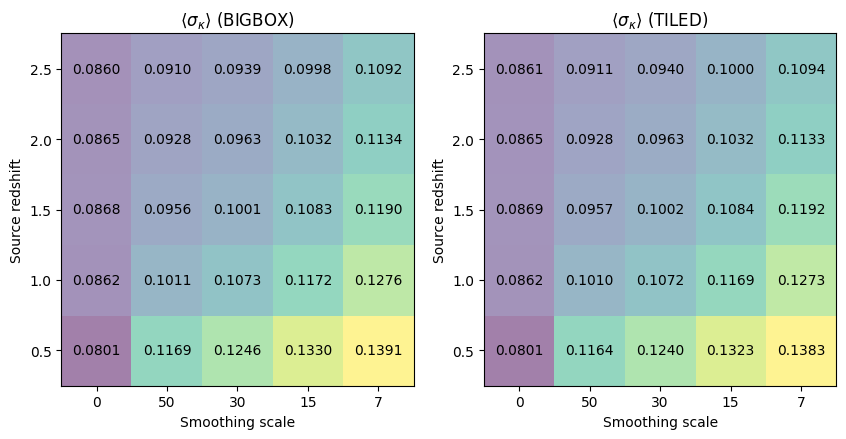

In [33]:

lenx = 5
leny = 5

fig, ax = plt.subplots(1, 2, figsize=(10, 7))

ax[0].imshow(np.array(means_bigbox).reshape(lenx, leny), alpha=0.5, origin="lower")
ax[1].imshow(np.array(means_tiled).reshape(lenx, leny), alpha=0.5, origin="lower")

ax[0].set_title(r"$\langle \sigma_\kappa \rangle$" + " (BIGBOX)")
ax[1].set_title(r"$\langle \sigma_\kappa \rangle$" + " (TILED)")

ax[0].set_xticks(np.arange(leny))
ax[0].set_xticklabels(ngal_list)
ax[0].set_yticks(np.arange(lenx))
ax[0].set_yticklabels(zs_list)

ax[1].set_xticks(np.arange(leny))
ax[1].set_xticklabels(ngal_list)
ax[1].set_yticks(np.arange(lenx))
ax[1].set_yticklabels(zs_list)

ax[0].set_xlabel("Smoothing scale")
ax[1].set_xlabel("Smoothing scale")

ax[0].set_ylabel("Source redshift")
ax[1].set_ylabel("Source redshift")

for (i, j), val in np.ndenumerate(np.array(means_bigbox).reshape(lenx, leny)):
    ax[0].text(j, i, f"{val:.4f}", ha='center', va='center', color='black')

for (i, j), val in np.ndenumerate(np.array(means_tiled).reshape(lenx, leny)):
    ax[1].text(j, i, f"{val:.4f}", ha='center', va='center', color='black')

plt.show()

In [25]:
sl = 2

means_tiled = []
means_bigbox = []

for i, zs in enumerate(zs_list):
    tiled_results = insert_stats( [str(p) for p in tiled_dirs if f"zs{zs}" in p.name])
    bigbox_results = insert_stats( [str(p) for p in bigbox_dirs if f"zs{zs}" in p.name])
    for j, ngal in enumerate(ngal_list):
        mean_tiled = np.mean(tiled_results[str(ngal)][str(sl)]['sigma0'])
        mean_bigbox = np.mean(bigbox_results[str(ngal)][str(sl)]['sigma0'])

        means_tiled.append(mean_tiled)
        means_bigbox.append(mean_bigbox)


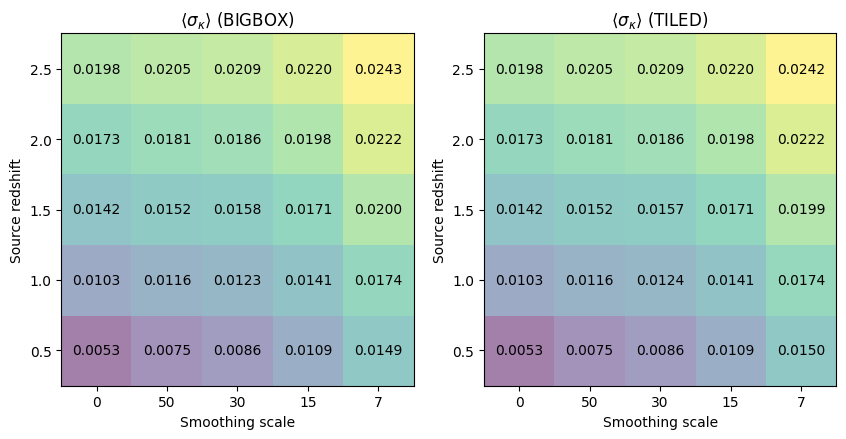

In [31]:
lenx = 5
leny = 5

fig, ax = plt.subplots(1, 2, figsize=(10, 7))

ax[0].imshow(np.array(means_bigbox).reshape(lenx, leny), alpha=0.5, origin="lower")
ax[1].imshow(np.array(means_tiled).reshape(lenx, leny), alpha=0.5, origin="lower")

ax[0].set_title(r"$\langle \sigma_\kappa \rangle$" + " (BIGBOX)")
ax[1].set_title(r"$\langle \sigma_\kappa \rangle$" + " (TILED)")

ax[0].set_xticks(np.arange(leny))
ax[0].set_xticklabels(ngal_list)
ax[0].set_yticks(np.arange(lenx))
ax[0].set_yticklabels(zs_list)

ax[1].set_xticks(np.arange(leny))
ax[1].set_xticklabels(ngal_list)
ax[1].set_yticks(np.arange(lenx))
ax[1].set_yticklabels(zs_list)

ax[0].set_xlabel("Smoothing scale")
ax[1].set_xlabel("Smoothing scale")

ax[0].set_ylabel("Source redshift")
ax[1].set_ylabel("Source redshift")

for (i, j), val in np.ndenumerate(np.array(means_bigbox).reshape(lenx, leny)):
    ax[0].text(j, i, f"{val:.4f}", ha='center', va='center', color='black')

for (i, j), val in np.ndenumerate(np.array(means_tiled).reshape(lenx, leny)):
    ax[1].text(j, i, f"{val:.4f}", ha='center', va='center', color='black')

plt.show()

# check equator

In [69]:
from matplotlib.gridspec import GridSpec, GridSpecFromSubplotSpec
from matplotlib.lines import Line2D

In [70]:
savedir = "/lustre/work/akira.tokiwa/Projects/LensingSSC/plot/BR"
os.makedirs(savedir, exist_ok=True)

nbin=8
lmin, lmax = 300, 3000
l_edges = np.logspace(np.log10(lmin), np.log10(lmax), nbin + 1, endpoint=True)
ell = (l_edges[1:] + l_edges[:-1]) / 2

bins = np.linspace(-4, 4, nbin+1, endpoint=True)
nu = (bins[1:] + bins[:-1]) / 2

In [71]:
positions = np.loadtxt("/lustre/work/akira.tokiwa/Projects/LensingSSC/meta/fibonacci_points.txt") # theta, phi

In [72]:
equator_threshold = np.radians(5) * np.sqrt(2)
longitude_threshold = np.radians(5) * np.sqrt(2)

black_list = [132]

mask_equator = np.abs(positions[:, 0] - np.pi/2) < equator_threshold
mask_longitude1 = np.abs(positions[:, 1]) < longitude_threshold
mask_longitude2 = np.abs(positions[:, 1] - np.pi /2) < longitude_threshold
mask_longitude3 = np.abs(positions[:, 1] - np.pi) < longitude_threshold
mask_longitude4 = np.abs(positions[:, 1] - 3*np.pi/2) < longitude_threshold
mask_longitude5 = np.abs(positions[:, 1] - 2*np.pi) < longitude_threshold


mask = mask_equator | mask_longitude1 | mask_longitude2 | mask_longitude3 | mask_longitude4 | mask_longitude5

In [73]:
indices_true = np.where(mask)[0]
indices_false = np.where(~mask)[0] 

# add black list to indices_false
indices_false = np.concatenate([indices_false, black_list])

In [74]:
# how many points remain
print(len(indices_true), len(indices_false))

71 195


In [75]:
stats_tiled_true, stats_bigbox_true = calculate_merged_stats(tiled_dirs, bigbox_dirs, zs_list, indices_true)
stats_tiled_false, stats_bigbox_false = calculate_merged_stats(tiled_dirs, bigbox_dirs, zs_list, indices_false)

/home/akira.tokiwa/.conda/envs/lssc/lib/python3.8/site-packages/numpy/lib/function_base.py:2829: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/home/akira.tokiwa/.conda/envs/lssc/lib/python3.8/site-packages/numpy/lib/function_base.py:2830: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


stats_tiled, consist from 3880 data points
stats_bigbox, consist from 2134 data points
stats_tiled, consist from 1400 data points
stats_bigbox, consist from 770 data points


# all

In [16]:
labels_ell = ["cl", "equilateral", "isosceles", "squeezed"]
titles_ell = ["$C_{\ell}$", "$B_{\ell}^{(eq)}$", "$B_{\ell}^{(iso)}$", "$B_{\ell}^{(sq)}$"]
ngal = "0"
fontsize = 16

labels_nu = ["pdf", "peaks", "minima", "v0", "v1", "v2"]
titles_nu = ["PDF", "Peaks", "Minima", "$V_0$", "$V_1$", "$V_2$"]
sl = "2"

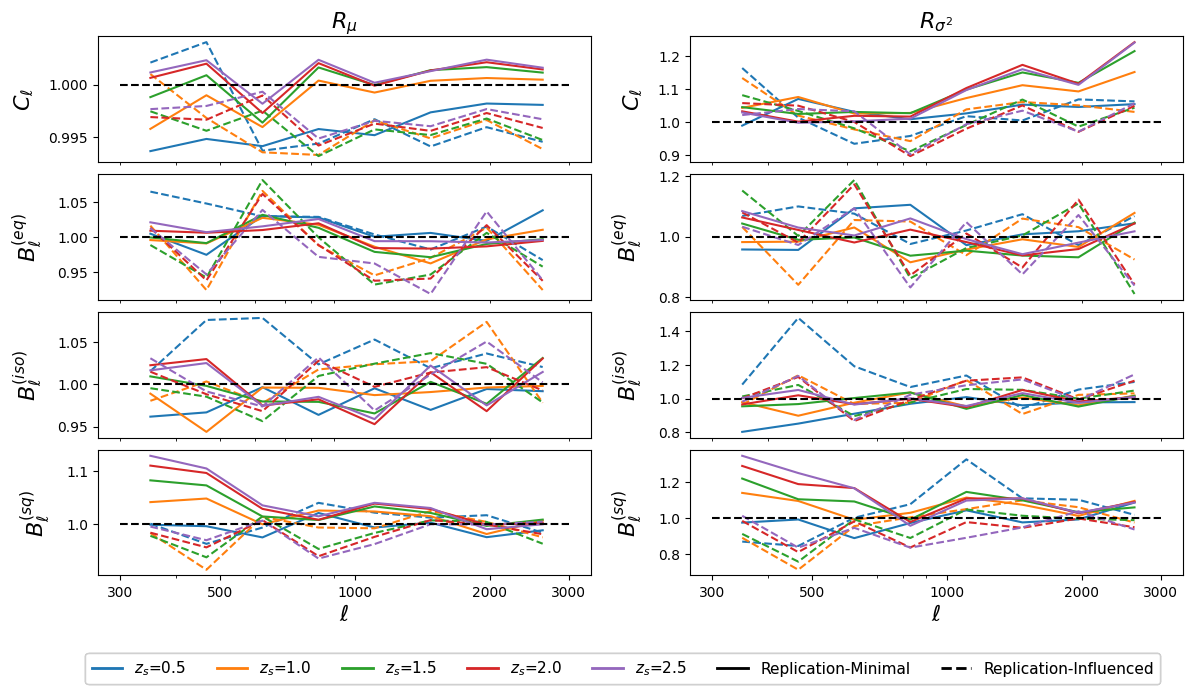

In [29]:


fig = plt.figure(figsize=(14, 7))
gs = GridSpec(4, 2, figure=fig, hspace=0.1, wspace=0.2)

ax_means = [fig.add_subplot(gs[i, 0]) for i in range(len(labels_ell))]
ax_vars = [fig.add_subplot(gs[i, 1]) for i in range(len(labels_ell))]

# プロットの主要部分は同じ
for i, label in enumerate(labels_ell):
    for j, zs in enumerate(zs_list):
        ax_means[i].plot(ell, stats_bigbox_true[zs][ngal][label]["means"]/stats_tiled_true[zs][ngal][label]["means"], color=colors[j])
        ax_vars[i].plot(ell, stats_bigbox_true[zs][ngal][label]["diags"]/stats_tiled_true[zs][ngal][label]["diags"], color=colors[j])

        ax_means[i].plot(ell, stats_bigbox_false[zs][ngal][label]["means"]/stats_tiled_false[zs][ngal][label]["means"], color=colors[j], linestyle="--")
        ax_vars[i].plot(ell, stats_bigbox_false[zs][ngal][label]["diags"]/stats_tiled_false[zs][ngal][label]["diags"], color=colors[j], linestyle="--")

    ax_means[i].hlines(1, lmin, lmax, linestyle="--", color="black")
    ax_vars[i].hlines(1, lmin, lmax, linestyle="--", color="black")

    # Y軸ラベルの位置を揃える
    ax_means[i].set_ylabel(f"{titles_ell[i]}", labelpad=10, fontsize=fontsize)
    ax_vars[i].set_ylabel(f"{titles_ell[i]}", labelpad=10, fontsize=fontsize)

    ax_means[i].set_xscale("log")
    ax_vars[i].set_xscale("log")

    # 最下段以外のx軸を非表示に
    if i < len(labels_ell) - 1:
        ax_means[i].set_xticks([])
        ax_vars[i].set_xticks([])
    else:
        # 最下段のx軸設定
        xticks = [300, 500, 1000, 2000, 3000]
        ax_means[i].set_xticks(xticks)
        ax_means[i].set_xticklabels(xticks)
        ax_vars[i].set_xticks(xticks)
        ax_vars[i].set_xticklabels(xticks)
        ax_means[i].set_xlabel("$\ell$", fontsize=fontsize)
        ax_vars[i].set_xlabel("$\ell$", fontsize=fontsize)

    # タイトルの設定
    if i == 0:
        ax_means[i].set_title("$R_{\mu}$", fontsize=fontsize)
        ax_vars[i].set_title("$R_{\sigma^2}$", fontsize=fontsize)

    # 凡例の設定
    custom_lines = [Line2D([0], [0], color=colors[j], lw=2) for j in range(len(zs_list))]
    custom_lines2 = [Line2D([0], [0], color="black", lw=2, linestyle=["-", "--"][j]) for j in range(2)]
    fig.legend(custom_lines + custom_lines2, [f"$z_s$={zs}" for zs in zs_list] + ["Replication-Minimal", "Replication-Influenced"], bbox_to_anchor=(0.5, 0.01), loc='upper center', ncol=7, fontsize=11)

fig.savefig(os.path.join(savedir, "BR_ratio_ell.png"), bbox_inches="tight")

In [30]:
def cal_corr_avg(corr):
    # Exclude diagonal and NaN values, then calculate the average
    mask = ~np.eye(corr.shape[0], dtype=bool) & ~np.isnan(corr)
    return np.nanmean(corr[mask])

def safe_mean(arr):
    # infとマイナスinfをnanに置き換え
    arr_no_inf = np.where(np.isinf(arr), np.nan, arr)
    return np.nanmean(arr_no_inf)

/var/tmp/pbs.311216.idark/ipykernel_248024/219237942.py:17: RuntimeWarning: invalid value encountered in true_divide
  ax_means[i].plot(nu, stats_bigbox_true[zs][ngal][sl][label]["means"]/stats_tiled_true[zs][ngal][sl][label]["means"], color=colors[j])
/var/tmp/pbs.311216.idark/ipykernel_248024/219237942.py:18: RuntimeWarning: invalid value encountered in true_divide
  ax_vars[i].plot(nu, stats_bigbox_true[zs][ngal][sl][label]["diags"]/stats_tiled_true[zs][ngal][sl][label]["diags"], color=colors[j])
/var/tmp/pbs.311216.idark/ipykernel_248024/219237942.py:20: RuntimeWarning: invalid value encountered in true_divide
  ax_means[i].plot(nu, stats_bigbox_false[zs][ngal][sl][label]["means"]/stats_tiled_false[zs][ngal][sl][label]["means"], color=colors[j], linestyle="--")
/var/tmp/pbs.311216.idark/ipykernel_248024/219237942.py:21: RuntimeWarning: invalid value encountered in true_divide
  ax_vars[i].plot(nu, stats_bigbox_false[zs][ngal][sl][label]["diags"]/stats_tiled_false[zs][ngal][sl][labe

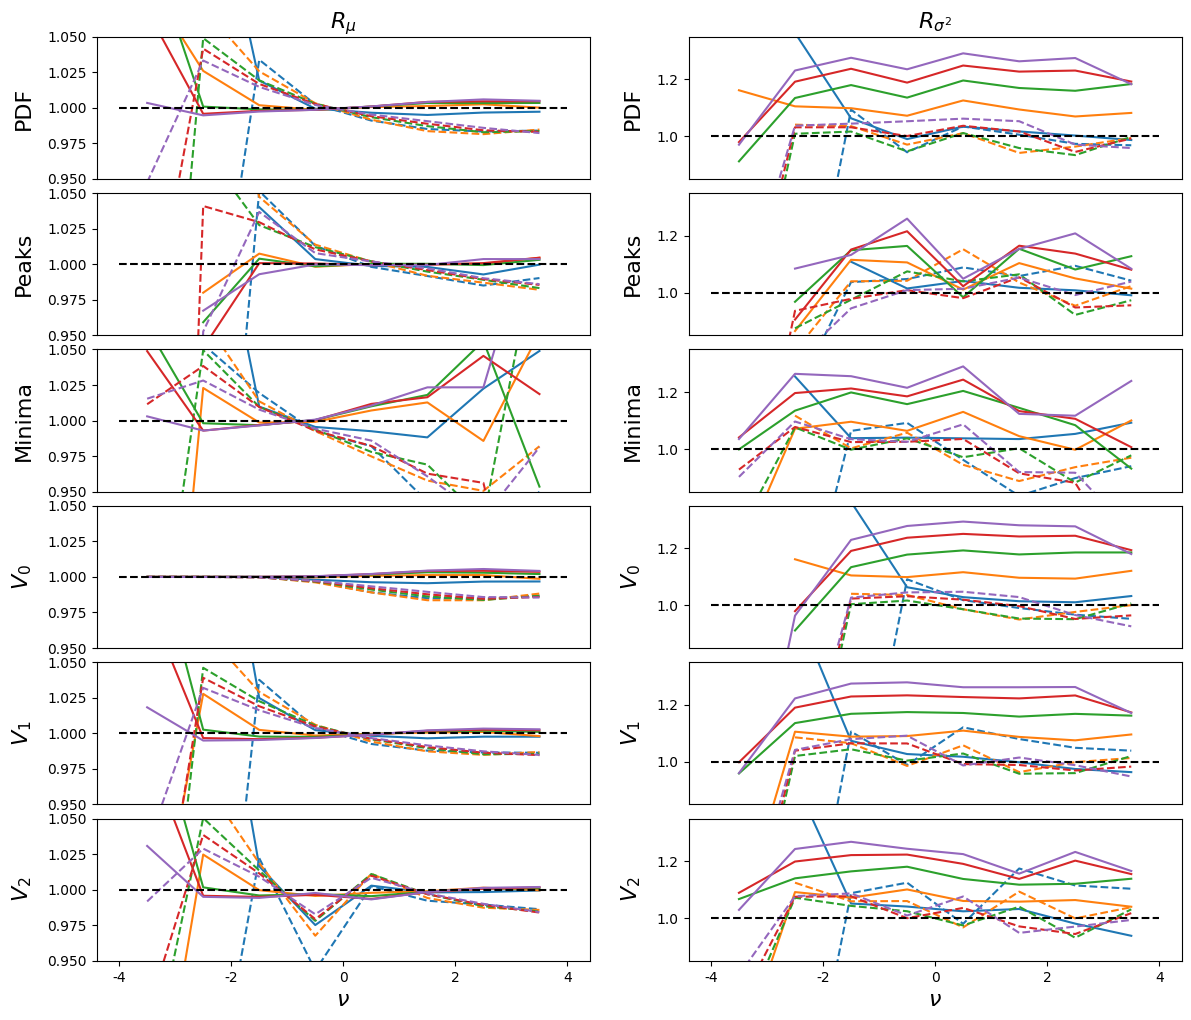

In [32]:


fig = plt.figure(figsize=(14, 12))
gs = GridSpec(6, 2, figure=fig, hspace=0.1, wspace=0.2)

ax_means = [fig.add_subplot(gs[i, 0]) for i in range(len(labels_nu))]
ax_vars = [fig.add_subplot(gs[i, 1]) for i in range(len(labels_nu))]

# プロットの主要部分は同じ
for i, label in enumerate(labels_nu):
    for j, zs in enumerate(zs_list):
        if label == "minima":
            ax_means[i].plot(nu, stats_bigbox_true[zs][ngal][sl][label]["means"][::-1]/stats_tiled_true[zs][ngal][sl][label]["means"][::-1], color=colors[j])
            ax_vars[i].plot(nu, stats_bigbox_true[zs][ngal][sl][label]["diags"][::-1]/stats_tiled_true[zs][ngal][sl][label]["diags"][::-1], color=colors[j])

            ax_means[i].plot(nu, stats_bigbox_false[zs][ngal][sl][label]["means"][::-1]/stats_tiled_false[zs][ngal][sl][label]["means"][::-1], color=colors[j], linestyle="--")
            ax_vars[i].plot(nu, stats_bigbox_false[zs][ngal][sl][label]["diags"][::-1]/stats_tiled_false[zs][ngal][sl][label]["diags"][::-1], color=colors[j], linestyle="--")
        else:
            ax_means[i].plot(nu, stats_bigbox_true[zs][ngal][sl][label]["means"]/stats_tiled_true[zs][ngal][sl][label]["means"], color=colors[j])
            ax_vars[i].plot(nu, stats_bigbox_true[zs][ngal][sl][label]["diags"]/stats_tiled_true[zs][ngal][sl][label]["diags"], color=colors[j])

            ax_means[i].plot(nu, stats_bigbox_false[zs][ngal][sl][label]["means"]/stats_tiled_false[zs][ngal][sl][label]["means"], color=colors[j], linestyle="--")
            ax_vars[i].plot(nu, stats_bigbox_false[zs][ngal][sl][label]["diags"]/stats_tiled_false[zs][ngal][sl][label]["diags"], color=colors[j], linestyle="--")

    ax_means[i].set_ylim(0.95, 1.05)
    ax_vars[i].set_ylim(0.85, 1.35)

    ax_means[i].hlines(1, -4, 4, linestyle="--", color="black")
    ax_vars[i].hlines(1, -4, 4, linestyle="--", color="black")

    # Y軸ラベルの位置を揃える
    ax_means[i].set_ylabel(f"{titles_nu[i]}", labelpad=10, fontsize=fontsize)
    ax_vars[i].set_ylabel(f"{titles_nu[i]}", labelpad=10, fontsize=fontsize)

    # 最下段以外のx軸を非表示に
    if i < len(labels_nu) - 1:
        ax_means[i].set_xticks([])
        ax_vars[i].set_xticks([])
    else:
        # 最下段のx軸設定
        xticks = [-4, -2, 0, 2, 4]
        ax_means[i].set_xticks(xticks)
        ax_means[i].set_xticklabels(xticks)
        ax_vars[i].set_xticks(xticks)
        ax_vars[i].set_xticklabels(xticks)
        ax_means[i].set_xlabel("$\\nu$", fontsize=fontsize)
        ax_vars[i].set_xlabel("$\\nu$", fontsize=fontsize)

    # タイトルの設定
    if i == 0:
        ax_means[i].set_title("$R_{\\mu}$", fontsize=fontsize)
        ax_vars[i].set_title("$R_{\\sigma^2}$", fontsize=fontsize)

    # 凡例の設定
    custom_lines = [Line2D([0], [0], color=colors[j], lw=2) for j in range(len(zs_list))]
    #ax_means[3].legend(custom_lines, [f"$z_s$={zs}" for zs in zs_list], loc="lower left", fontsize=10)

    # legend about the linestyles
    custom_lines = [Line2D([0], [0], color="black", lw=2, linestyle=["-", "--"][j]) for j in range(2)]
    #ax_vars[1].legend(custom_lines, ["Rest", "Suspect"], loc="upper left", fontsize=10)

fig.savefig(os.path.join(savedir, "BR_ratio_nu.png"), bbox_inches="tight")

/var/tmp/pbs.311216.idark/ipykernel_248024/1468460471.py:48: RuntimeWarning: invalid value encountered in true_divide
  tmp_cov = stats_bigbox_false[zs][ngal][sl][label]["cov"] / stats_tiled_false[zs][ngal][sl][label]["cov"]
/var/tmp/pbs.311216.idark/ipykernel_248024/1468460471.py:46: RuntimeWarning: invalid value encountered in true_divide
  tmp_cov = stats_bigbox_false[zs][ngal][sl][label]["cov"][::-1, ::-1] / stats_tiled_false[zs][ngal][sl][label]["cov"][::-1, ::-1]


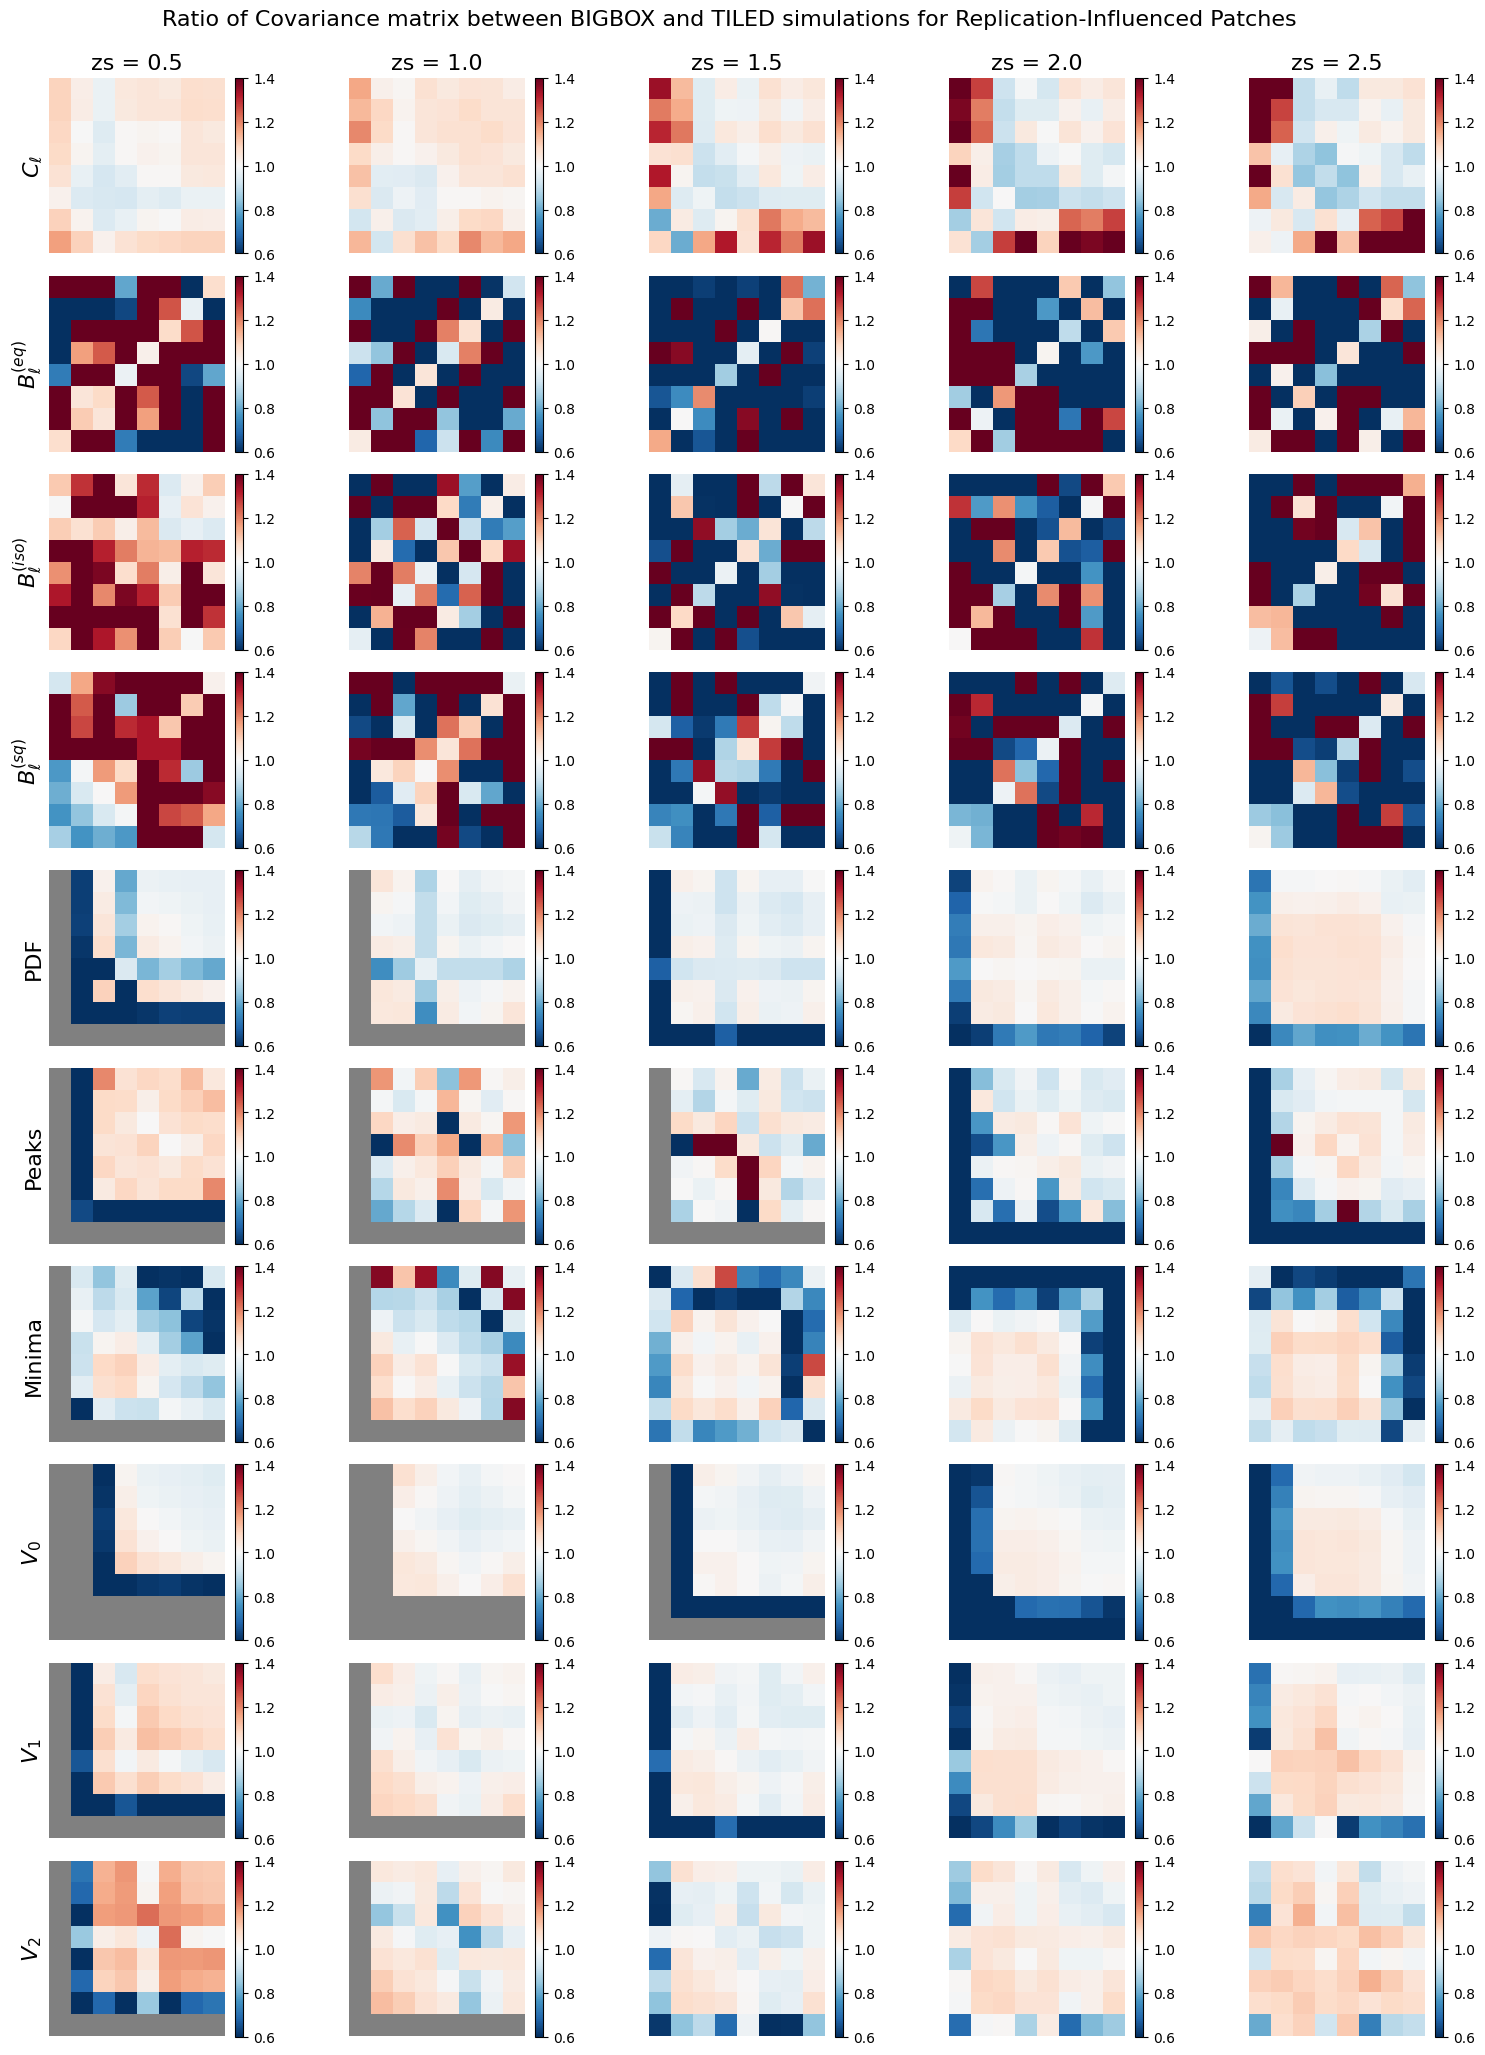

In [57]:
cmap = plt.get_cmap("RdBu_r")
cmap.set_bad(color="gray")

cbarrange = []

fig, ax = plt.subplots(
    len(labels_ell) + len(labels_nu),
    len(zs_list),
    figsize=(3 * len(zs_list), 2 * (len(labels_ell) + len(labels_nu))),
    constrained_layout=True
)

# add a main title
fig.suptitle("Ratio of Covariance matrix between BIGBOX and TILED simulations for Replication-Influenced Patches", fontsize=16, y=1.02)

for i, zs in enumerate(zs_list):
    #zs = str(zs_i)
    
    # Plot for labels_ell
    for j, label in enumerate(labels_ell):
        tmp_cov = stats_bigbox_false[zs][ngal][label]["cov"] / stats_tiled_false[zs][ngal][label]["cov"]
        im = ax[j, i].imshow(tmp_cov, cmap=cmap, origin="lower", vmin=0.6, vmax=1.4)
        fig.colorbar(im, ax=ax[j, i], fraction=0.046, pad=0.04)
        cbarrange.append(im.get_clim())
        
        # Set title only for the top row
        if j == 0:
            ax[j, i].set_title(f"zs = {zs}", fontsize=16)
        
        # Set y-axis label only for the first column
        if i == 0:
            ax[j, i].set_ylabel(titles_ell[j], fontsize=16)
        
        # Hide ticks
        ax[j, i].tick_params(left=False, bottom=False, labelleft=False, labelbottom=False)
        
        # Optionally, hide spines for a cleaner look
        for spine in ax[j, i].spines.values():
            spine.set_visible(False)
    
    # Plot for labels_nu
    for j, label in enumerate(labels_nu):
        row_index = j + len(labels_ell)

        if label == "minima":
            tmp_cov = stats_bigbox_false[zs][ngal][sl][label]["cov"][::-1, ::-1] / stats_tiled_false[zs][ngal][sl][label]["cov"][::-1, ::-1]
        else:
            tmp_cov = stats_bigbox_false[zs][ngal][sl][label]["cov"] / stats_tiled_false[zs][ngal][sl][label]["cov"]
        im = ax[row_index, i].imshow(tmp_cov, cmap=cmap, origin="lower", vmin=0.6, vmax=1.4)
        fig.colorbar(im, ax=ax[row_index, i], fraction=0.046, pad=0.04)
        cbarrange.append(im.get_clim())
        
        # Set title only for the top row
        if row_index == 0:
            ax[row_index, i].set_title(f"zs = {zs}", fontsize=16)
        
        # Set y-axis label only for the first column
        if i == 0:
            ax[row_index, i].set_ylabel(titles_nu[j], fontsize=16)
        
        # Hide ticks
        ax[row_index, i].tick_params(left=False, bottom=False, labelleft=False, labelbottom=False)
        
        # Optionally, hide spines for a cleaner look
        for spine in ax[row_index, i].spines.values():
            spine.set_visible(False)

plt.show()
fig.savefig(os.path.join(savedir, "cov_ratio_RIP.png"), bbox_inches="tight")


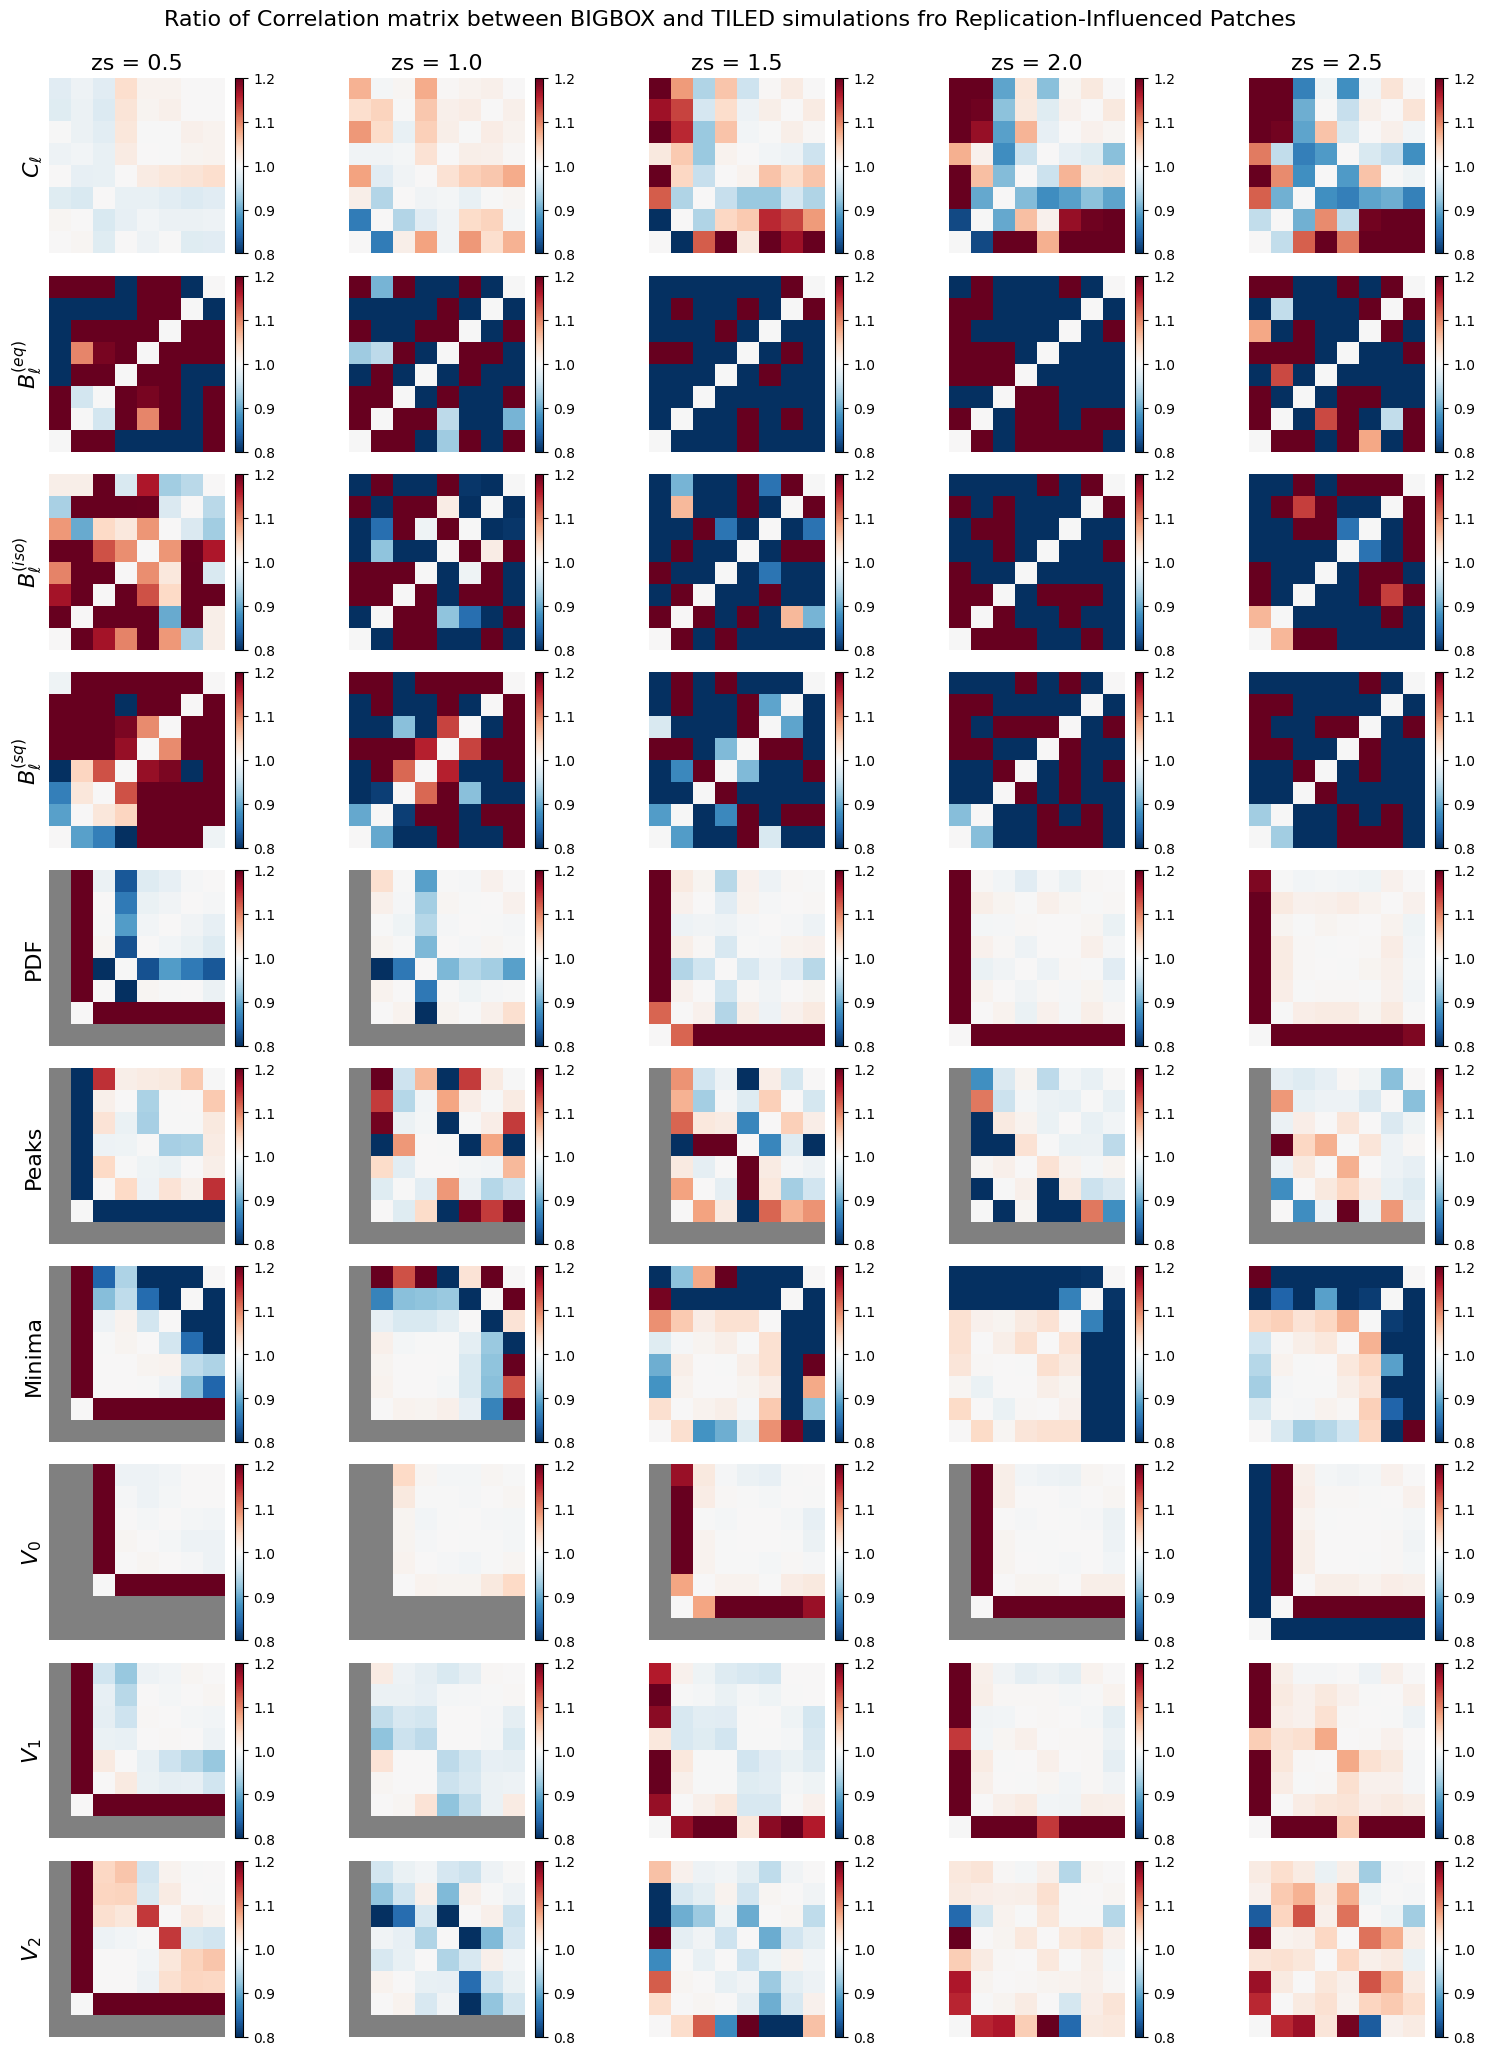

In [58]:
cmap = plt.get_cmap("RdBu_r")
cmap.set_bad(color="gray")

cbarrange = []

fig, ax = plt.subplots(
    len(labels_ell) + len(labels_nu),
    len(zs_list),
    figsize=(3 * len(zs_list), 2 * (len(labels_ell) + len(labels_nu))),
    constrained_layout=True
)

# add a main title
fig.suptitle("Ratio of Correlation matrix between BIGBOX and TILED simulations fro Replication-Influenced Patches", fontsize=16, y=1.02)

for i, zs in enumerate(zs_list):
    #zs = str(zs_i)
    
    # Plot for labels_ell
    for j, label in enumerate(labels_ell):

        tmp_corr = stats_bigbox_false[zs][ngal][label]["corr"] / stats_tiled_false[zs][ngal][label]["corr"]
        im = ax[j, i].imshow(tmp_corr, cmap=cmap, origin="lower", vmin=0.8, vmax=1.2)
        fig.colorbar(im, ax=ax[j, i], fraction=0.046, pad=0.04)
        cbarrange.append(im.get_clim())
        
        # Set title only for the top row
        if j == 0:
            ax[j, i].set_title(f"zs = {zs}", fontsize=16)
        
        # Set y-axis label only for the first column
        if i == 0:
            ax[j, i].set_ylabel(titles_ell[j], fontsize=16)
        
        # Hide ticks
        ax[j, i].tick_params(left=False, bottom=False, labelleft=False, labelbottom=False)
        
        # Optionally, hide spines for a cleaner look
        for spine in ax[j, i].spines.values():
            spine.set_visible(False)
    
    # Plot for labels_nu
    for j, label in enumerate(labels_nu):
        row_index = j + len(labels_ell)

        if label == "minima":
            tmp_corr = stats_bigbox_false[zs][ngal][sl][label]["corr"][::-1, ::-1] / stats_tiled_false[zs][ngal][sl][label]["corr"][::-1, ::-1]
        else:
            tmp_corr = stats_bigbox_false[zs][ngal][sl][label]["corr"] / stats_tiled_false[zs][ngal][sl][label]["corr"]
        im = ax[row_index, i].imshow(tmp_corr, cmap=cmap, origin="lower", vmin=0.8, vmax=1.2)
        fig.colorbar(im, ax=ax[row_index, i], fraction=0.046, pad=0.04)
        cbarrange.append(im.get_clim())
        
        # Set title only for the top row
        if row_index == 0:
            ax[row_index, i].set_title(f"zs = {zs}", fontsize=16)
        
        # Set y-axis label only for the first column
        if i == 0:
            ax[row_index, i].set_ylabel(titles_nu[j], fontsize=16)
        
        # Hide ticks
        ax[row_index, i].tick_params(left=False, bottom=False, labelleft=False, labelbottom=False)
        
        # Optionally, hide spines for a cleaner look
        for spine in ax[row_index, i].spines.values():
            spine.set_visible(False)

plt.show()
fig.savefig(os.path.join(savedir, "corr_ratio_RIP.png"), bbox_inches="tight")


In [39]:
result_cov_true = [[] for _ in range(len(zs_list))]
result_cov_false = [[] for _ in range(len(zs_list))]
result_corr_true = [[] for _ in range(len(zs_list))]
result_corr_false = [[] for _ in range(len(zs_list))]
except_indices = [(1, nbin-1)] * len(labels_nu)

for i, zs in enumerate(zs_list):
    for label in labels_ell:
        result_cov_true[i].append(safe_mean(stats_bigbox_true[zs][ngal][label]['cov'] / stats_tiled_true[zs][ngal][label]['cov']))
        result_cov_false[i].append(safe_mean(stats_bigbox_false[zs][ngal][label]['cov'] / stats_tiled_false[zs][ngal][label]['cov']))

    for j, label in enumerate(labels_nu):
        rmin, rmax = except_indices[j]
        if label == "minima":
            tmp_cov_true = stats_bigbox_true[zs][ngal][sl][label]['cov'][::-1, ::-1] / stats_tiled_true[zs][ngal][sl][label]['cov'][::-1, ::-1]
            tmp_cov_false = stats_bigbox_false[zs][ngal][sl][label]['cov'][::-1, ::-1] / stats_tiled_false[zs][ngal][sl][label]['cov'][::-1, ::-1]
        else:
            tmp_cov_true = stats_bigbox_true[zs][ngal][sl][label]['cov'] / stats_tiled_true[zs][ngal][sl][label]['cov']
            tmp_cov_false = stats_bigbox_false[zs][ngal][sl][label]['cov'] / stats_tiled_false[zs][ngal][sl][label]['cov']

        result_cov_true[i].append(safe_mean(tmp_cov_true[rmin:rmax, rmin:rmax]))
        result_cov_false[i].append(safe_mean(tmp_cov_false[rmin:rmax, rmin:rmax]))

    for label in labels_ell:
        result_corr_true[i].append(cal_corr_avg(stats_bigbox_true[zs][ngal][label]['corr'] / stats_tiled_true[zs][ngal][label]['corr']))
        result_corr_false[i].append(cal_corr_avg(stats_bigbox_false[zs][ngal][label]['corr'] / stats_tiled_false[zs][ngal][label]['corr']))

    for j, label in enumerate(labels_nu):
        rmin, rmax = except_indices[j]
        if label == "minima":
            tmp_corr_true = stats_bigbox_true[zs][ngal][sl][label]['corr'][::-1, ::-1] / stats_tiled_true[zs][ngal][sl][label]['corr'][::-1, ::-1]
            tmp_corr_false = stats_bigbox_false[zs][ngal][sl][label]['corr'][::-1, ::-1] / stats_tiled_false[zs][ngal][sl][label]['corr'][::-1, ::-1]
        else:
            tmp_corr_true = stats_bigbox_true[zs][ngal][sl][label]['corr'] / stats_tiled_true[zs][ngal][sl][label]['corr']
            tmp_corr_false = stats_bigbox_false[zs][ngal][sl][label]['corr'] / stats_tiled_false[zs][ngal][sl][label]['corr']

        result_corr_true[i].append(cal_corr_avg(tmp_corr_true[rmin:rmax, rmin:rmax]))
        result_corr_false[i].append(cal_corr_avg(tmp_corr_false[rmin:rmax, rmin:rmax]))

result_cov_true = np.array(result_cov_true)
result_cov_false = np.array(result_cov_false)
result_corr_true = np.array(result_corr_true)
result_corr_false = np.array(result_corr_false)


/var/tmp/pbs.311216.idark/ipykernel_248024/2263676075.py:18: RuntimeWarning: invalid value encountered in true_divide
  tmp_cov_true = stats_bigbox_true[zs][ngal][sl][label]['cov'] / stats_tiled_true[zs][ngal][sl][label]['cov']
/var/tmp/pbs.311216.idark/ipykernel_248024/2263676075.py:19: RuntimeWarning: invalid value encountered in true_divide
  tmp_cov_false = stats_bigbox_false[zs][ngal][sl][label]['cov'] / stats_tiled_false[zs][ngal][sl][label]['cov']
/var/tmp/pbs.311216.idark/ipykernel_248024/2263676075.py:18: RuntimeWarning: divide by zero encountered in true_divide
  tmp_cov_true = stats_bigbox_true[zs][ngal][sl][label]['cov'] / stats_tiled_true[zs][ngal][sl][label]['cov']
/var/tmp/pbs.311216.idark/ipykernel_248024/2263676075.py:15: RuntimeWarning: invalid value encountered in true_divide
  tmp_cov_true = stats_bigbox_true[zs][ngal][sl][label]['cov'][::-1, ::-1] / stats_tiled_true[zs][ngal][sl][label]['cov'][::-1, ::-1]
/var/tmp/pbs.311216.idark/ipykernel_248024/2263676075.py:16:

In [41]:
labels_ell = ["cl", "equilateral", "isosceles", "squeezed"]
titles_ell = ["$C_{\ell}$", "$B_{\ell}^{(eq)}$", "$B_{\ell}^{(iso)}$", "$B_{\ell}^{(sq)}$"]
ngal = "0"
fontsize = 16

labels_nu = ["pdf", "peaks", "minima", "v0", "v1", "v2"]
titles_nu = ["PDF", "Peaks", "Minima", "$V_0$", "$V_1$", "$V_2$"]
sl = "2"

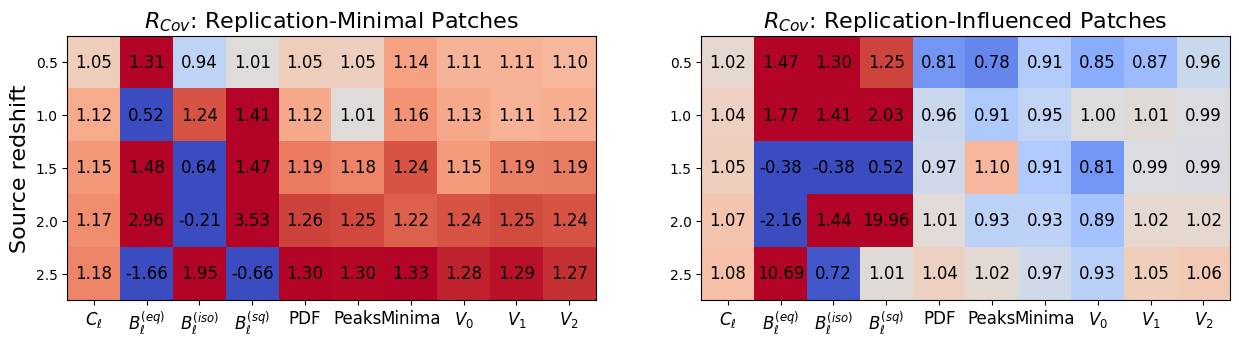

In [48]:
lenx = result_cov_true.shape[0]
leny = result_cov_true.shape[1]

fig, ax = plt.subplots(1, 2, figsize=(15, 7))

ax[0].imshow(result_cov_true, cmap="coolwarm", vmin=0.7, vmax=1.3)
ax[1].imshow(result_cov_false, cmap="coolwarm", vmin=0.7, vmax=1.3)

ax[0].set_xticks(np.arange(len(labels_ell + labels_nu)))
ax[0].set_xticklabels(titles_ell + titles_nu, fontsize=12)
ax[1].set_xticks(np.arange(len(labels_ell + labels_nu)))
ax[1].set_xticklabels(titles_ell + titles_nu, fontsize=12)

ax[0].set_yticks(np.arange(lenx))
ax[0].set_yticklabels(zs_list)
ax[1].set_yticks(np.arange(lenx))
ax[1].set_yticklabels(zs_list)

ax[0].set_ylabel("Source redshift", fontsize=16)
#ax[1].set_ylabel("Source redshift", fontsize=16)

ax[0].set_title("$R_{Cov}$: Replication-Minimal Patches", fontsize=16)
ax[1].set_title("$R_{Cov}$: Replication-Influenced Patches", fontsize=16)

for (i, j), val in np.ndenumerate(result_cov_true):
    ax[0].text(j, i, f"{val:.2f}", ha='center', va='center', color='black', fontsize=12)

for (i, j), val in np.ndenumerate(result_cov_false):
    ax[1].text(j, i, f"{val:.2f}", ha='center', va='center', color='black', fontsize=12)

fig.savefig(os.path.join(savedir, "BR_avg_cov_ratio.png"), bbox_inches="tight")


# Save data

In [84]:
for i, zs in enumerate(zs_list):
    tiled_results = insert_stats( [str(p) for p in tiled_dirs if f"zs{zs}" in p.name])
    bigbox_results = insert_stats( [str(p) for p in bigbox_dirs if f"zs{zs}" in p.name])

    for ngal in ngal_list:
        for j, sl in enumerate(sl_list):
            stats_tiled_true[zs][str(ngal)][str(sl)]['sigma0'] = np.mean(tiled_results[str(ngal)][str(sl)]['sigma0'])
            stats_bigbox_true[zs][str(ngal)][str(sl)]['sigma0'] = np.mean(bigbox_results[str(ngal)][str(sl)]['sigma0'])

            stats_tiled_true[zs][str(ngal)][str(sl)]['sigma1'] = np.mean(tiled_results[str(ngal)][str(sl)]['sigma1'])
            stats_bigbox_true[zs][str(ngal)][str(sl)]['sigma1'] = np.mean(bigbox_results[str(ngal)][str(sl)]['sigma1'])

In [85]:
stats_tiled_true[zs][str(ngal)][str(sl)]['sigma0']

0.011035794

In [86]:
# save merged stats
save_dir = Path("/lustre/work/akira.tokiwa/Projects/LensingSSC/output/merged")
os.makedirs(save_dir, exist_ok=True)
#save_merged_stats_to_hdf5(merged_stats_tiled, save_dir / "merged_stats_tiled.h5")
#save_merged_stats_to_hdf5(merged_stats_bigbox, save_dir / "merged_stats_bigbox.h5")

save_merged_stats_to_hdf5(stats_tiled_true, save_dir / "merged_stats_tiled_true.h5")
save_merged_stats_to_hdf5(stats_bigbox_true, save_dir / "merged_stats_bigbox_true.h5")

In [248]:
hdf5_path = "/lustre/work/akira.tokiwa/Projects/LensingSSC/output/merged/merged_stats_bigbox.h5"

# Open the HDF5 file in read mode and load the data
with h5py.File(hdf5_path, 'r') as hdf5_file:
    data = load_dict_from_hdf5(hdf5_file)